# Przetwarzanie języka naturalnego


## Wstęp

Obecnie najpopularniejsze model służące do przetwarzania języka naturalnego wykorzystują architekturę transformacyjną. Istnieje kilka bibliotek, implementujących tę architekturę, ale w kontekście NLP najczęściej wykorzystuje się [Huggingface transformers](https://huggingface.co/docs/transformers/index).

Biblioteka ta poza samym [kodem źródłowym](https://github.com/huggingface/transformers), zawiera szereg innych elementów. Do najważniejszych z nich należą:
* [modele](https://huggingface.co/models) - olbrzymia i ciągle rosnąca liczba gotowych modeli, których możemy użyć do rozwiązywania wielu problemów z dziedziny NLP (ale również w zakresie rozpoznawania mowy, czy przetwarzania obrazu),
* [zbiory danych](https://huggingface.co/datasets) - bardzo duży katalog przydatnych zbiorów danych, które możemy w prosty sposób wykorzystać do trenowania własnych modeli NLP (oraz innych modeli).

## Weryfikacja dostępności GPU

Trening modeli NLP wymaga dostępu do akceleratorów sprzętowych, przyspieszających uczenie sieci neuronowych. Jeśli nasz komputer nie jest wyposażony w GPU, to możemy skorzystać ze środowiska Google Colab.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/apohllo/sztuczna-inteligencja/blob/master/lab5/lab_5.ipynb)

W tym środowisku możemy wybrać akcelerator spośród GPU i TPU.

Sprawdźmy, czy mamy dostęp do środowiska wyposażonego w akcelerator NVidii:

In [ ]:
!nvidia-smi

Sun Dec 15 16:01:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Jeśli akcelerator jest niedostępny (polecenie skończyło się błędem), to zmieniamy środowisko wykonawcze wybierając z menu "Środowisko wykonawcze" -> "Zmień typ środowiska wykonawczego" -> GPU.

## Podpięcie dysku Google (opcjonalne)

Kolejnym elementem przygotowań, który jest opcjonalny, jest dołączenie własnego dysku Google Drive do środowiska Colab. Dzięki temu możliwe jest zapisywanie wytrenowanych modeli, w trakcie procesu treningu, na "zewnętrznym" dysku. Jeśli Google Colab doprowadzi do przerwania procesu treningu, to mimo wszystko pliki, które udało się zapisać w trakcie treningu nie przepadną. Możliwe będzie wznowienie treningu już na częściowo wytrenowanym modelu.

W tym celu montujemy dysk Google w Colabie. Wymaga to autoryzacji narzędzia Colab w Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Po podmontowaniu dysku mamy dostęp do całej zawartości Google Drive. Wskazując miejsce zapisywania danych w trakcie treningu należy wskazać ścieżkę zaczynającą się od `/content/gdrive`, ale należy wskazać jakiś podkatalog w ramach naszej przestrzeni dyskowej. Pełna ścieżka może mieć postać `/content/gdrive/MyDrive/output`. Przed uruchomieniem treningu warto sprawdzić, czy dane zapisują się na dysku.

## Instalacja bibliotek Pythona

Podobnie jak w poprzednich laboratoriach optymalnym sposobem instalacji bibliotek jest wykorzystanie narzędzia Poetry, które ma ustalone wersji bibliotek w pliku `poetry.lock`. Biblioteki te zostały zmodyfikowane względem wcześniejszych laboratoriów, dlatego ponownie powinniśmy jest zainstalować.

Mając zainstalowane niezbedne bilioteki, możemy skorzystać z wszystkich modeli i zbiorów danych zarejestrowanych w katalogu.

Typowym sposobem użycia dostępnych modeli jest:
* *wykorzystanie gotowego modelu*, który realizuje określone zadanie, np. [analizę senetymentu w języku angielskim](https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis) - model tego rodzaju nie musi być trenowywany, wystarczy go uruchomić aby uzyskać wynik klasyfikacji (można to zobaczyć w demo pod wskazanym linkiem),
* *wykorzystanie modelu bazowego*, który jest dotrenowywany do określonego zadania; przykładem takiego modelu jest [HerBERT base](https://huggingface.co/allegro/herbert-base-cased), który uczony był jako maskowany model języka. Żeby wykorzystać go do konkretnego zadania, musimy wybrać dla niego "głowę klasyfikacyjną" oraz dotrenować na własnym zbiorze danych.

Modele tego rodzaju różnią się od siebie, można je załadować za pomocą wspólnego interfejsu, ale najlepiej jest wykorzystać jedną ze specjalizowanych klas, dostosowanych do zadania, które chcemy zrealizować. Zaczniemy od załadowania modelu BERT base - jednego z najbardziej popularnych modeli, dla języka angielskiego. Za jego pomocą będziemy odgadywać brakujące wyrazy w tekście. Wykorzystamy do tego wywołanie `AutoModelForMaskedLM`.

In [111]:
from transformers import AutoModelForMaskedLM, AutoTokenizer

model = AutoModelForMaskedLM.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Załadowany model jest modułem PyTorcha. Możemy zatem korzystać z API tej biblioteki. Możemy np. sprawdzić ile parametrów ma model BERT base:

In [112]:
count = sum(p.numel() for p in model.parameters() if p.requires_grad)

'{:,}'.format(count).replace(',', ' ')

'108 340 804'

Widzimi zatem, że nasz model jest bardzo duży - zawiera ponad 100 milionów parametrów, a jest to tzw. model bazowy. Modele obecnie wykorzystywane mają jeszcze więcej parametrów - duże modele językowe, takie jak ChatGPT posiadają więcej niż 100 miliardów parametrów.

Możemy również podejrzeć samą strukturę modelu.

In [113]:
model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

Jeśli dysponujemy akceleratorem (GPU lub inny), to pamiętajmy żeby przeniść model na ten akcelerator, np.

In [114]:
# Jeśli chcesz użyć akceleratora wpisz "cuda:0" lub nazwę odpowiedniego akceleratora.
# Żeby kod poniżej dział, ale obliczenia były wykonywane na CPU, wpisz "cpu"
#device = "cpu"
device = "cuda:0"
model.to(device)
print("")

# Tokenizacja tekstu

Załadowanie samego modelu nie jest jednak wystarczające, żeby zacząć go wykorzystywać. Musimy mieć mechanizm zamiany tekstu (łańcucha znaków), na ciąg tokenów, należących do określonego słownika. W trakcie treningu modelu, słownik ten jest określany (wybierany w sposób algorytmiczny) przed właściwym treningiem sieci neuronowej. Choć możliwe jest jego późniejsze rozszerzenie (douczenie na danych treningowych, pozwala również uzyskać reprezentację brakujących tokenów), to zwykle wykorzystuje się słownik w postaci, która została określona przed treningiem sieci neuronowej. Dlatego tak istotne jest wskazanie właściwego słownika dla tokenizera dokonującego podziału tekstu.

Biblioteka posiada klasę `AutoTokenizer`, która akceptuje nazwę modelu, co pozwala automatycznie załadować słownik korespondujący z wybranym modelem sieci neuronowej. Trzeba jednak pamiętać, że jeśli używamy 2 modeli, to każdy z nich najpewniej będzie miał inny słownik, a co za tym idzie muszą one mieć własne instancje klasy `Tokenizer`.

In [115]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

Tokenizer posługuje się słownikiem o stałym rozmiarze. Podowuje to oczywiście, że nie wszystkie wyrazy występujące w tekście, będą się w nim znajdowały. Co więcej, jeśli użyjemy tokenizera do podziału tekstu w innym języku, niż ten dla którego został on stworzony, to taki tekst będzie dzielony na większą liczbę tokenów.

In [116]:
sentence1 = tokenizer.encode(
    "The quick brown fox jumps over the lazy dog.", return_tensors="pt"
)
print(sentence1)
print(sentence1.shape)

sentence2 = tokenizer.encode("Zażółć gęślą jaźń.", return_tensors="pt")
print(sentence2)
print(sentence2.shape)

tensor([[  101,  1109,  3613,  3058, 17594, 15457,  1166,  1103, 16688,  3676,
           119,   102]])
torch.Size([1, 12])
tensor([[  101,   163,  1161, 28259,  7774, 20671,  7128,   176, 28221, 28244,
          1233, 28213,   179,  1161, 28257, 19339,   119,   102]])
torch.Size([1, 18])


Korzystająć z tokenizera dla języka angielsiego do podziału polskiego zdania, widzimy, że otrzymujemy znacznie większą liczbę tokenów. Żeby zobaczyć, w jaki sposób tokenizer dokonał podziału tekstu, możemy wykorzystać wywołanie `covert_ids_to_tokens`:

In [117]:
print("|".join(tokenizer.convert_ids_to_tokens(list(sentence1[0]))))
print("|".join(tokenizer.convert_ids_to_tokens(list(sentence2[0]))))

[CLS]|The|quick|brown|fox|jumps|over|the|lazy|dog|.|[SEP]
[CLS]|Z|##a|##ż|##ó|##ł|##ć|g|##ę|##ś|##l|##ą|j|##a|##ź|##ń|.|[SEP]


Widzimy, że dla jęzka angielskiego wszystkie wyrazy w zdaniu zostały przekształcone w pojedyncze tokeny. W przypadku zdania w języku polskim, zawierającego szereg znaków diakrytycznych sytuacja jest zupełnie inna - każdy znak został wyodrębniony do osobnego sub-tokenu. To, że mamy do czynienia z sub-tokenami sygnalizowane jest przez dwa krzyżyki poprzedzające dany sub-token. Oznaczają one, że ten sub-token musi być sklejony z porzedzającym go tokenem, aby uzyskać właściwy łańcuch znaków.

## Zadanie 1 (0.5 punkt)

Wykorzystaj tokenizer dla modelu `allegro/herbert-base-cased`, aby dokonać tokenizacji tych samych zdań. Jakie wnioski można wyciągnąć przyglądając się sposobowi tokenizacji za pomocą różnych słowników?

In [118]:
!pip install sacremoses
!pip install datasets
!pip install evaluate

In [119]:
# your_code
tokenizer_pl = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")

sentence1 = tokenizer_pl.encode(
    "The quick brown fox jumps over the lazy dog.", return_tensors="pt"
)

sentence2 = tokenizer_pl.encode("Zażółć gęślą jaźń.", return_tensors="pt")

print("|".join(tokenizer_pl.convert_ids_to_tokens(list(sentence1[0]))))
print("|".join(tokenizer_pl.convert_ids_to_tokens(list(sentence2[0]))))


<s>|The</w>|qui|ck</w>|brow|n</w>|fo|x</w>|ju|mp|s</w>|o|ver</w>|the</w>|la|zy</w>|do|g</w>|.</w>|</s>
<s>|Za|żół|ć</w>|gę|ślą</w>|ja|ź|ń</w>|.</w>|</s>


// odpowiedź \
Tokenizacja różni się w zależności od wybranego słownika. Używając tokenizera przystosowanego do angielskich wyrazów do zdania po polsku, które zawierało dużo polskich liter, każda z liter została zaklasyfikowana jako osobny token. W zdaniu angielskim widzimy, że każde słowo to osobny token. Natomiast używając 'polskiego tokenizera' widać, że niektóre litery w polskim zdaniu zostały połaczone, tworząc jeden token. Dla zdania po angielsku obserwujemy, że otrzymaliśmy znacznie więcej tokenów niż w pierwszym przypadku.

W wynikach tokenizacji poza wyrazami/tokenami występującymi w oryginalnym tekście pojawiają się jeszcze dodatkowe znaczniki `[CLS]` oraz `[SEP]` (albo inne znaczniki - w zależności od użytego słownika). Mają one specjalne znaczenie i mogą być wykorzystywane do realizacji specyficznych funkcji związanych z analizą tekstu. Np. reprezentacja tokenu `[CLS]` wykorzystywana jest w zadaniach klasyfikacji zdań. Z kolei token `[SEP]` wykorzystywany jest do odróżnienia zdań, w zadaniach wymagających na wejściu dwóch zdań (np. określenia, na ile zdania te są podobne do siebie).


# Modelowanie języka

Modele pretrenowane w reżimie self-supervised learning (SSL) nie posiadają specjalnych zdolności w zakresie rozwiązywania konkretnych zadań z zakresu przetwarzania języka naturalnego, takich jak odpowiadanie na pytania, czy klasyfikacja tekstu (z wyjątkiem bardzo dużych modeli, takich jak np. GPT-3, których model językowy zdolny jest do predykcji np. sensownych odpowiedzi na pytania). Można je jednak wykorzystać do określania prawdopodobieństwa wyrazów w tekście, a tym samym do sprawdzenia, jaką wiedzę posiada określony model w zakresie znajomości języka, czy też ogólną wiedzę o świecie.

Aby sprawdzić jak model radzi sobie w tych zadaniach, możemy dokonać inferencji na danych wejściowych, w których niektóre wyrazy zostaną zastąpione specjalnymi symbolami maskującymi, wykorzystywanymi w trakcie pre-treningu modelu.

Należy mieć na uwadze, że różne modele mogą korzystać z różnych specjalnych sekwencji w trakcie pretreningu. Np. Bert korzysta z sekwencji `[MASK]`. Wygląd tokenu maskującego lub jego identyfikator możemy sprawdzić w [pliku konfiguracji tokenizera](https://huggingface.co/bert-base-cased/raw/main/tokenizer.json) dystrubowanym razem z modelem, albo odczytać wprost z instancji tokenizera.

W pierwszej kolejności, spróbujemy uzupełnić brakujący wyraz w angielskim zdaniu.

In [120]:
sentence_en_text = "The quick brown [MASK] jumps over the lazy dog."

sentence_en = tokenizer.encode(
    sentence_en_text, return_tensors="pt"
)
#
print("|".join(tokenizer.convert_ids_to_tokens(list(sentence_en[0]))))
target = model(sentence_en.to(device))
print(target.logits[0][4])

[CLS]|The|quick|brown|[MASK]|jumps|over|the|lazy|dog|.|[SEP]
tensor([-5.3489, -5.6063, -5.1303,  ..., -5.9625, -4.1559, -4.5403],
       device='cuda:0', grad_fn=<SelectBackward0>)


Ponieważ zdanie po stokenizowaniu uzupełniane jest znacznikiem `[CLS]`, to zamaskowane słowo znajduje się na 4 pozycji. Wywołanie `target.logits[0][4]` pokazuje tensor z rozkładem prawdopodobieństwa poszczególnych wyrazów, które zostało określone na podstawie parametrów modelu. Możemy wybrać wyrazy, które posiadają największe prawdopodobieństwo, korzystając z wywołania `torch.topk`:

In [121]:
import torch

top = torch.topk(target.logits[0][4], 5)
top

torch.return_types.topk(
values=tensor([12.1982, 11.2289, 10.6009, 10.1278, 10.0120], device='cuda:0',
       grad_fn=<TopkBackward0>),
indices=tensor([ 3676,  1663,  5855,  4965, 21566], device='cuda:0'))

Otrzymaliśmy dwa wektory - `values` zawierający składowe wektora wyjściowego sieci neuronowej (nieznormalizowane) oraz `indices` zawierający indeksy tych składowych. Na tej podstawie możemy wyświetlić wyraz, które według modelu są najbardziej prawdopodobnymi uzupełnieniami zamaskowanego wyrazu:

In [122]:
words = tokenizer.convert_ids_to_tokens(top.indices)

<BarContainer object of 5 artists>

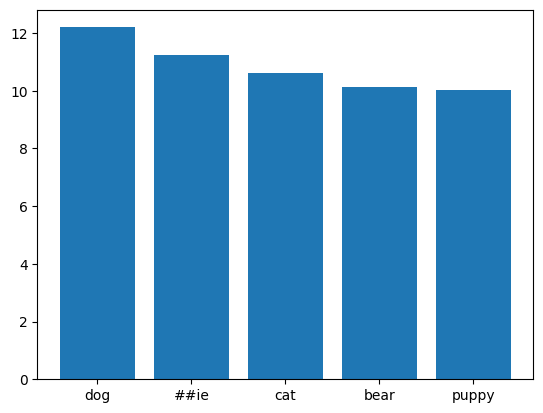

In [123]:
import matplotlib.pyplot as plt

plt.bar(words, top.values.cpu().detach().numpy())

Według modelu najbardziej prawdopodobnym uzupełnieniem brakującego wyrazu jest `dog` (a nie `fox`). Nieco zaskakujący może być drugi wyraz `##ie`, ale po dodaniu go do istniejącego tekstu otrzymamy zdanie: "The quick brownie jumps over the lazy dog", które również wydaje się sensowne (choć nieco zaskakujące).

## Zadanie 2 (1.5 punkty)

Wykorzystując model `allegro/herbert-base-cased` zaproponuj zdania z jednym brakującym wyrazem, weryfikujące zdolność tego modelu do:
* odmiany przez polskie przypadki,
* uwzględniania długodystansowych związków w tekście,
* reprezentowania wiedzy o świecie.

Dla każdego problemu wymyśl po 3 zdania sprawdzające i wyświetl predykcję dla 5 najbardziej prawdopodobnych wyrazów.

Możesz wykorzystać kod z funkcji `plot_words`, który ułatwi Ci wyświetlanie wyników. Zweryfikuj również jaki token maskujący wykorzystywany jest w tym modelu. Pamiętaj również o załadowaniu modelu `allegro/herbert-base-cased`.

Oceń zdolności modelu w zakresie wskazanych zadań.

In [124]:
tokenizer_pl = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
model_pl = AutoModelForMaskedLM.from_pretrained("allegro/herbert-base-cased")
model_pl.to(device);

In [125]:
def plot_words(sentence, word_model, word_tokenizer, mask="[MASK]"):
    sentence = word_tokenizer.encode(sentence, return_tensors="pt")
    tokens = word_tokenizer.convert_ids_to_tokens(list(sentence[0]))
    print("|".join(tokens))
    target = word_model(sentence.to(device))
    top = torch.topk(target.logits[0][tokens.index(mask)], 5)
    words = word_tokenizer.convert_ids_to_tokens(top.indices)
    mask_token = word_tokenizer.encode(mask, add_special_tokens=False)[0]
    token_ids = list(sentence[0].cpu().detach().numpy())
    mask_index = token_ids.index(mask_token)
    for word_id in top.indices:
        token_ids[mask_index]  = word_id
        print(word_tokenizer.decode(token_ids, skip_special_tokens=True))

    plt.xticks(rotation=45)
    plt.bar(words, top.values.cpu().detach().numpy())
    plt.show()


<s>|Wczoraj</w>|A|la</w>|<mask>|na</w>|spacer</w>|.</w>|</s>
Wczoraj Ala wyszła na spacer .
Wczoraj Ala poszła na spacer .
Wczoraj Ala pojechała na spacer .
Wczoraj Ala szła na spacer .
Wczoraj Ala wyjechała na spacer .


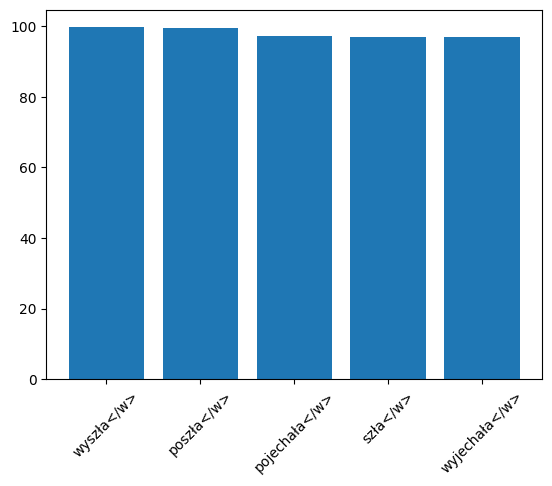

<s>|Jutro</w>|moi</w>|rodzice</w>|<mask>|ze</w>|znajomymi</w>|w</w>|restauracji</w>|.</w>|</s>
Jutro moi rodzice będą ze znajomymi w restauracji .
Jutro moi rodzice są ze znajomymi w restauracji .
Jutro moi rodzice zostaną ze znajomymi w restauracji .
Jutro moi rodzice zagrają ze znajomymi w restauracji .
Jutro moi rodzice zostają ze znajomymi w restauracji .


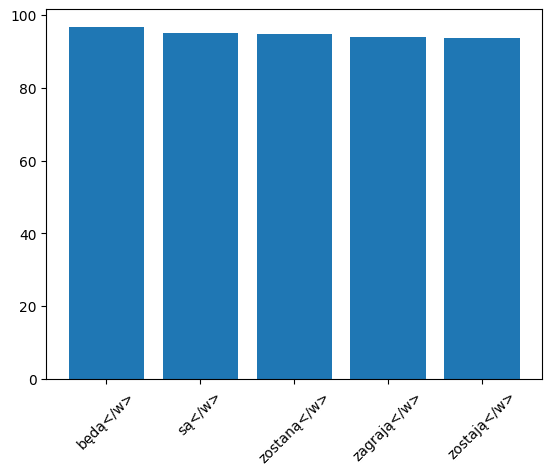

<s>|Chciałbym</w>|zapytać</w>|<mask>|o</w>|zdanie</w>|,</w>|ale</w>|nie</w>|mam</w>|na</w>|tyle</w>|odwagi</w>|</s>
Chciałbym zapytać kogoś o zdanie , ale nie mam na tyle odwagi
Chciałbym zapytać Was o zdanie , ale nie mam na tyle odwagi
Chciałbym zapytać was o zdanie , ale nie mam na tyle odwagi
Chciałbym zapytać się o zdanie , ale nie mam na tyle odwagi
Chciałbym zapytać Pana o zdanie , ale nie mam na tyle odwagi


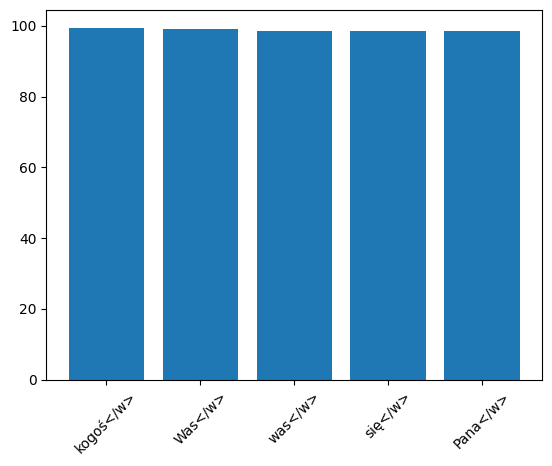

In [126]:
# odmiana przez przypadki

sentences = ["Wczoraj Ala <mask> na spacer.",
             "Jutro moi rodzice <mask> ze znajomymi w restauracji.",
             "Chciałbym zapytać <mask> o zdanie, ale nie mam na tyle odwagi"]


for s in sentences:
  plot_words(s, model_pl, tokenizer_pl, '<mask>')

<s>|Na</w>|ostatnich</w>|zawodach</w>|zaj|ąłem</w>|drugie</w>|miejsce</w>|.</w>|Mogę</w>|więc</w>|z</w>|dumą</w>|powiedzieć</w>|,</w>|że</w>|zostałem</w>|<mask>|Polski</w>|</s>
Na ostatnich zawodach zająłem drugie miejsce . Mogę więc z dumą powiedzieć , że zostałem mistrzem Polski
Na ostatnich zawodach zająłem drugie miejsce . Mogę więc z dumą powiedzieć , że zostałem wicemistrzem Polski
Na ostatnich zawodach zająłem drugie miejsce . Mogę więc z dumą powiedzieć , że zostałem reprezentantem Polski
Na ostatnich zawodach zająłem drugie miejsce . Mogę więc z dumą powiedzieć , że zostałem mistrzynią Polski
Na ostatnich zawodach zająłem drugie miejsce . Mogę więc z dumą powiedzieć , że zostałem zawodnikiem Polski


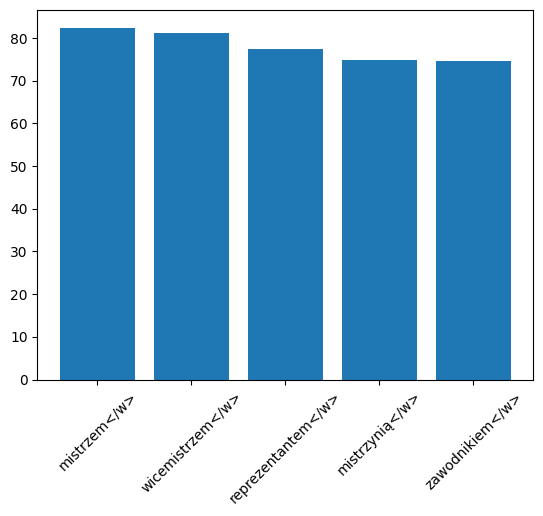

<s>|Uwielbi|am</w>|wspólnie</w>|bawić</w>|się</w>|z</w>|siostrą</w>|i</w>|bratem</w>|.</w>|Cieszę</w>|się</w>|,</w>|że</w>|nie</w>|jestem</w>|<mask>|,</w>|tak</w>|jak</w>|mój</w>|kuzy|n</w>|Wojtek</w>|.</w>|</s>
Uwielbiam wspólnie bawić się z siostrą i bratem . Cieszę się , że nie jestem sam , tak jak mój kuzyn Wojtek .
Uwielbiam wspólnie bawić się z siostrą i bratem . Cieszę się , że nie jestem sama , tak jak mój kuzyn Wojtek .
Uwielbiam wspólnie bawić się z siostrą i bratem . Cieszę się , że nie jestem samotny , tak jak mój kuzyn Wojtek .
Uwielbiam wspólnie bawić się z siostrą i bratem . Cieszę się , że nie jestem dzieckiem , tak jak mój kuzyn Wojtek .
Uwielbiam wspólnie bawić się z siostrą i bratem . Cieszę się , że nie jestem mamą , tak jak mój kuzyn Wojtek .


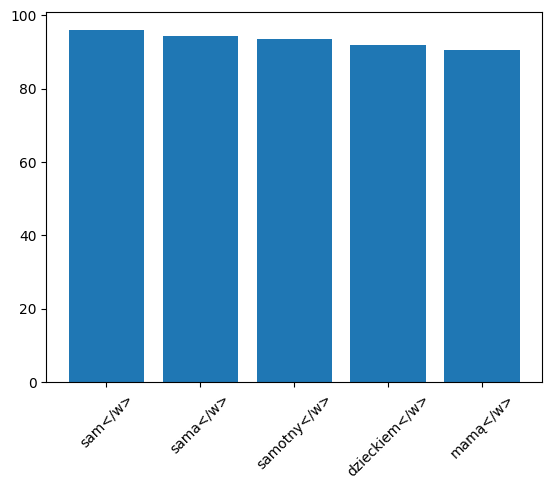

<s>|Moja</w>|cio|cia</w>|jest</w>|<mask>|,</w>|od</w>|zawsze</w>|chciała</w>|pomagać</w>|innym</w>|a</w>|teraz</w>|spełni|ła</w>|swoje</w>|marzenie</w>|i</w>|pracuje</w>|w</w>|szpitalu</w>|.</w>|</s>
Moja ciocia jest mamą , od zawsze chciała pomagać innym a teraz spełniła swoje marzenie i pracuje w szpitalu .
Moja ciocia jest lekarzem , od zawsze chciała pomagać innym a teraz spełniła swoje marzenie i pracuje w szpitalu .
Moja ciocia jest chora , od zawsze chciała pomagać innym a teraz spełniła swoje marzenie i pracuje w szpitalu .
Moja ciocia jest szczęśliwa , od zawsze chciała pomagać innym a teraz spełniła swoje marzenie i pracuje w szpitalu .
Moja ciocia jest kobietą , od zawsze chciała pomagać innym a teraz spełniła swoje marzenie i pracuje w szpitalu .


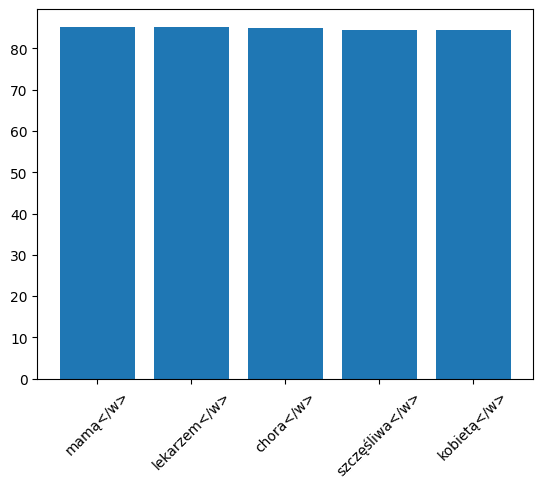

In [127]:
# długodystansowe związki w tekście

sentences = ["Na ostatnich zawodach zająłem drugie miejsce. Mogę więc z dumą powiedzieć, że zostałem <mask> Polski",
             "Uwielbiam wspólnie bawić się z siostrą i bratem. Cieszę się, że nie jestem <mask>, tak jak mój kuzyn Wojtek.",
             "Moja ciocia jest <mask>, od zawsze chciała pomagać innym a teraz spełniła swoje marzenie i pracuje w szpitalu."]


for s in sentences:
  plot_words(s, model_pl, tokenizer_pl, '<mask>')

<s>|<mask>|jest</w>|naj|dłuższą</w>|polską</w>|rzeką</w>|.</w>|</s>
Odra jest najdłuższą polską rzeką .
Wisła jest najdłuższą polską rzeką .
Warta jest najdłuższą polską rzeką .
Wisłoka jest najdłuższą polską rzeką .
Biała jest najdłuższą polską rzeką .


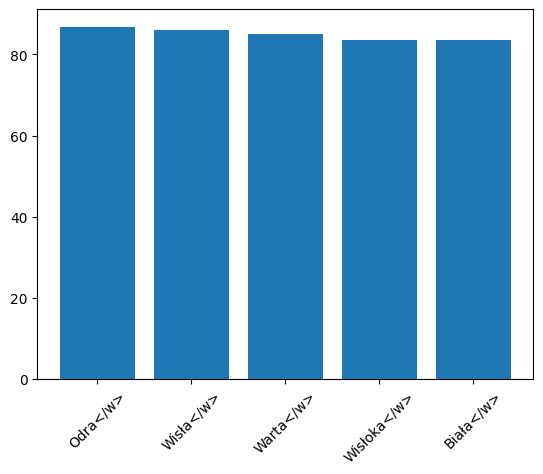

<s>|Największa</w>|planeta</w>|Układu</w>|Słone|cznego</w>|to</w>|<mask>|</s>
Największa planeta Układu Słonecznego to :
Największa planeta Układu Słonecznego to …
Największa planeta Układu Słonecznego to Ziemia
Największa planeta Układu Słonecznego to Mars
Największa planeta Układu Słonecznego to .


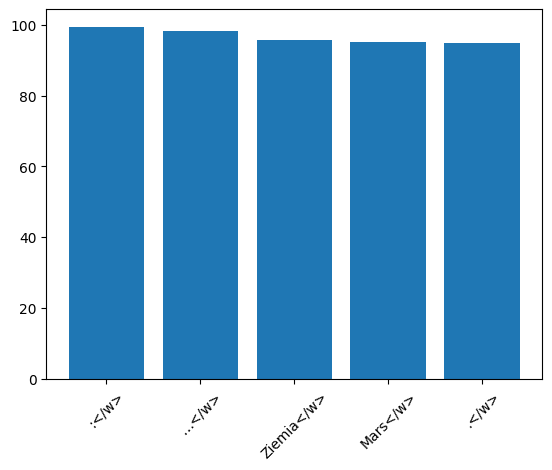

<s>|Kontynen|t</w>|,</w>|na</w>|którym</w>|leży</w>|Meksyk</w>|to</w>|<mask>|.</w>|</s>
Kontynent , na którym leży Meksyk to Australia .
Kontynent , na którym leży Meksyk to Europa .
Kontynent , na którym leży Meksyk to Brazylia .
Kontynent , na którym leży Meksyk to Ameryka .
Kontynent , na którym leży Meksyk to Hiszpania .


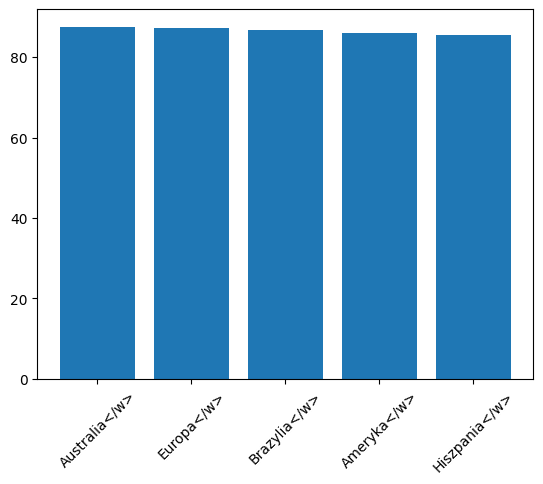

In [128]:
# wiedza o świecie
sentences = ["<mask> jest najdłuższą polską rzeką.",
             "Największa planeta Układu Słonecznego to <mask>",
             "Kontynent, na którym leży Meksyk to <mask>."]


for s in sentences:
  plot_words(s, model_pl, tokenizer_pl, '<mask>')

// odpowiedź \
Model dość dobrze radzi sobie z polską odmianą i wstawia poprawną formę wyrazu w brakujące miejsce. W przypadku długodystansowych związków w tekście zdarza się, że otrzymamy poprawne uzupełnienie zdania, ale są też przykładu, w których wstawiony wyraz nie jest do końca trafny. Zdania dotyczące wiedzy o świecie nie zawsze uzupełniane są poprawie. Być może modelowi brakuje informacji. Wstawiane wyrazy pasują jednak w sensie poprawności gramatycznej.

# Klasyfikacja tekstu

Pierwszym zadaniem, które zrealizujemy korzystając z modelu HerBERT będzie klasyfikacja tekstu. Będzie to jednak dość nietypowe zadanie. O ile oczekiwanym wynikiem jest klasyfikacja binarna, czyli dość popularny typ klasyfikacji, o tyle dane wejściowe są nietypowe, gdyż są to pary: `(pytanie, kontekst)`. Celem algorytmu jest określenie, czy na zadane pytanie można odpowiedzieć na podstawie informacji znajdujących się w kontekście.

Model tego rodzaju jest nietypowy, ponieważ jest to zadanie z zakresu klasyfikacji par tekstów, ale my potraktujemy je jak zadanie klasyfikacji jednego tekstu, oznaczając jedynie fragmenty tekstu jako `Pytanie:` oraz `Kontekst:`. Wykorzystamy tutaj zdolność modeli transformacyjnych do automatycznego nauczenia się tego rodzaju znaczników, przez co proces przygotowania danych będzie bardzo uproszczony.

Zbiorem danych, który wykorzystamy do treningu i ewaluacji modelu będzie PoQUAD - zbiór inspirowany angielskim [SQuADem](https://rajpurkar.github.io/SQuAD-explorer/), czyli zbiorem zawierającym ponad 100 tys. pytań i odpowiadających im odpowiedzi. Zbiór ten powstał niedawno i jest jeszcze rozbudowywany. Zawiera on pytania, odpowiedzi oraz konteksty, na podstawie których można udzielić odpowiedzi.

W dalszej części laboratorium skoncentrujemy się na problemie odpowiadania na pytania.

## Przygotowanie danych do klasyfikacji

Przygotowanie danych rozpoczniemy od sklonowania repozytorium zawierającego pytania i odpowiedzi.

In [129]:
from datasets import load_dataset

dataset = load_dataset("clarin-pl/poquad")

Sprawdźmy co znajduje się w zbiorze danych.

In [130]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 46187
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5764
    })
})

Zbiór danych jest podzielony na dwie części: treningową i walidacyjną. Rozmiar części treningowej to ponad 46 tysięcy pytań i odpowiedzi, natomiast części walidacyjnej to ponad 5 tysięcy pytań i odpowiedzi.

Dane zbioru przechowywane są w plikach `poquad_train.json` oraz `poquad_dev.json`. Dostarczenie podziału na te grupy danych jest bardzo częstą praktyką w przypadku publicznych, dużych zbiorów danych, gdyż umożliwia porównywanie różnych modeli, korzystając z dokładnie takiego samego zestawu danych. Prawdopodobnie istnieje również zbiór `poquad_test.json`, który jednak nie jest udostępniany publicznie. Tak jest w przypadku SQuADu - twórcy zbioru automatycznie ewaluują dostarczane modele, ale nie udstoępniaja zbioru testowego. Dzięki temu trudniej jest nadmiernie dopasować model do danych testowych.

Struktura każdej z dostępnych części jest taka sama. Zgodnie z powyższą informacją zawiera ona następujące elementy:
* `id` - identyfikator pary: pytanie - odpowiedź,
* `title` - tytuł artykułu z Wikipedii, na podstawie którego utworzono parę,
* `context` - fragment treści artykułu z Wikipedii, zawierający odpowiedź na pytanie,
* `question` - pytanie,
* `answers` - odpowiedzi.

Możemy wyświetlić kilka począkotwych wpisów części treningowej:

In [131]:
dataset['train']['question'][:5]

['Co było powodem powrócenia konceptu porozumieniu monachijskiego?',
 'Pomiędzy jakimi stronami odbyło się zgromadzenie w sierpniu 1942 roku?',
 'O co ubiegali się polscy przedstawiciele podczas spotkania z sierpnia 1942 roku?',
 "Który z dyplomatów sprzeciwił się konceptowi konfederacji w listopadzie '42?",
 'Kiedy oficjalnie doszło do zawarcia porozumienia?']

In [132]:
dataset['train']['answers'][:5]

[{'text': ['wymianą listów Ripka – Stroński'], 'answer_start': [117]},
 {'text': ['E. Beneša i J. Masaryka z jednej a Wł. Sikorskiego i E. Raczyńskiego'],
  'answer_start': [197]},
 {'text': ['podpisanie układu konfederacyjnego'], 'answer_start': [315]},
 {'text': ['E. Beneš'], 'answer_start': [558]},
 {'text': ['20 listopada 1942'], 'answer_start': [691]}]

Niestety, autorzy zbioru danych, pomimo tego, że dane te znajdują się w źródłowym zbiorze danych, nie udostępniają dwóch ważnych informacji: o tym, czy można odpowiedzieć na dane pytanie oraz jak brzmi generatywna odpowiedź na pytanie. Dlatego póki nie zostanie to naprawione, będziemy dalej pracowąć z oryginalnymi plikami zbioru danych, które dostępne są na stronie opisującej zbiór danych: https://huggingface.co/datasets/clarin-pl/poquad/tree/main

Pobierz manualnie zbiory `poquad-dev.json` oraz `poquad-train.json`.

In [133]:
!wget https://huggingface.co/datasets/clarin-pl/poquad/raw/main/poquad-dev.json
!wget https://huggingface.co/datasets/clarin-pl/poquad/resolve/main/poquad-train.json

--2024-12-17 18:59:37--  https://huggingface.co/datasets/clarin-pl/poquad/raw/main/poquad-dev.json
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.23, 18.164.174.118, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6286317 (6.0M) [text/plain]
Saving to: ‘poquad-dev.json’

poquad-dev.json     100%[===================>]   5.99M  15.0MB/s    in 0.4s    

2024-12-17 18:59:37 (15.0 MB/s) - ‘poquad-dev.json’ saved [6286317/6286317]

--2024-12-17 18:59:37--  https://huggingface.co/datasets/clarin-pl/poquad/resolve/main/poquad-train.json
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.55, 18.164.174.118, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/18/de/18ded45e8046dd5f58b7365947f5a4298433a0e7710248308670e8cf26059c20/b1ac3acabb49fedb7b

Dla bezpieczeństwa, jeśli korzystamy z Google drive, to przeniesiemy pliki do naszego dysku:

In [134]:
!mkdir gdrive/MyDrive/poquad
!mv poquad-dev.json gdrive/MyDrive/poquad
!mv poquad-train.json gdrive/MyDrive/poquad

!head -30 gdrive/MyDrive/poquad/poquad-dev.json

mkdir: cannot create directory ‘gdrive/MyDrive/poquad’: File exists
{
  "version": "02-20",
  "data": [
    {
      "id": 9773,
      "title": "Miszna",
      "summary": "Miszna (hebr. ‏משנה‎ miszna „nauczać”, „ustnie przekazywać”, „studiować”, „badać”, od ‏שנה‎ szana „powtarzać”, „różnić się”, „być odmiennym”; jid. Miszne) – w judaizmie uporządkowany zbiór tekstów ustnego prawa uzupełniający Torę (Prawo pisane). Według wierzeń judaizmu stanowi ustną, niespisaną część prawa nadanego przez Boga na Synaju, tzw. Torę ustną. Jest świętym tekstem judaizmu i jest traktowana na równi z Tanach (Biblią hebrajską). Zbiór był w Izraelu od wieków przekazywany ustnie z pokolenia na pokolenie, zwiększył swój rozmiar szczególnie w okresie od III w. p.n.e. do II w. n.e. w wyniku systematycznego uzupełniania komentarzy przez tannaitów, żydowskich nauczycieli prawa ustnego. Miszna została spisana dopiero w II–III w. Prace redakcyjne zapoczątkował rabin Akiba ben Josef, a kształt ostatecznej redakcji tek

Struktura pliku odpowiada strukturze danych w zbiorze SQuAD. Dane umieszczone są w kluczu `data` i podzielone na krotki odpowiadające pojedynczym artykułom Wikipedii. W ramach artykułu może być wybranych jeden lub więcej paragrafów, dla których w kluczu `qas` pojawiają się pytania (`question`), flaga `is_impossible`, wskazujace czy można odpowiedzieć na pytanie oraz odpowiedzi (o ile nie jest ustawiona flaga `is_impossible`). Odpowiedzi może być wiele i składają się one z treści odpowiedzi (`text`) traktowanej jako fragment kontekstu, a także naturalnej odpowiedzi na pytanie (`generative_answer`).

Taki podział może wydawać się dziwny, ale zbiór SQuAD zawiera tylko odpowiedzi pierwszego rodzaju. Wynika to z faktu, że w języku angielskim fragment tekstu będzie często stanowił dobrą odpowiedź na pytanie (oczywiście z wyjątkiem pytań dla których odpowiedź to `tak` lub `nie`).

Natomiast ten drugi typ odpowiedzi jest szczególnie przydatny dla języka polskiego, ponieważ często odpowiedź chcemy syntaktycznie dostosować do pytania, co jest niemożliwe, jeśli odpowiedź wskazywana jest jako fragment kontekstu.
W sytuacji, w której odpowiedzi były określane w sposób automatyczny, są one oznaczone jako `plausible_answers`.



## Ładowanie danych

Zaczniemy od wczytania danych i wyświetlenia podstawowych statystyk dotyczących ilości artykułów oraz przypisanych do nich pytań.

In [135]:
import json

# Adjust for your needs
# path = "."
path = 'gdrive/MyDrive/poquad'

with open(path + "/poquad-train.json") as input:
    train_data = json.loads(input.read())["data"]

print(f"Train data articles: {len(train_data)}")

with open(path +"/poquad-dev.json") as input:
    dev_data = json.loads(input.read())["data"]

print(f"Dev data articles: {len(dev_data)}")

print(f"Train questions: {sum([len(e['paragraphs'][0]['qas']) for e in train_data])}")
print(f"Dev questions: {sum([len(e['paragraphs'][0]['qas']) for e in dev_data])}")

Train data articles: 8553
Dev data articles: 1402
Train questions: 41577
Dev questions: 6809


Ponieważ w pierwszym problemie chcemy stwierdzić, czy na pytanie można udzielić odpowiedzi na podstawie kontekstu, połączymy wszystkie konteksty w jedną tablicę, aby móc losować z niej dane negatywne, gdyż liczba pytań nie posiadających odpowiedzi jest stosunkowo mała, co prowadziłoby utworzenia niezbalansowanego zbioru.

In [136]:
all_contexts = [e["paragraphs"][0]["context"] for e in train_data] + [
    e["paragraphs"][0]["context"] for e in dev_data
]

W kolejnym kroku zamieniamy dane w formacie JSON na reprezentację zgodną z przyjętym założeniem.
Chcemy by kontekst oraz pytanie występowały obok siebie i każdy z elementów był sygnalizowany wyrażeniem: `Pytanie:` i `Kontekst:`. Treść klasyfikowanego tekstu przyporządkowujemy do klucza `text`, natomiast klasę do klucza `label`, gdyż takie są oczekiwanie biblioteki Transformer.

Pytania, które mają ustawiną flagę `is_impossible` na `True` trafiają wprost do przekształconego zbioru. Dla pytań, które posiadają odpowiedź, dodatkowo losowany jest jeden kontekst, który stanowi negatywny przykład. Weryfikujemy tylko, czy kontekst ten nie pokrywa się z kontekstem, który przypisany był do pytania. Nie przeprowadzamy bardziej zaawansowanych analiz, które pomogłyby wylkuczyć sytuację, w której inny kontekst również zawiera odpowiedź na pytanie, gdyż prawdopodobieństwo wylosowania takiego kontekstu jest bardzo małe.

Na końcu wyświetlamy statystyki utworzonego zbioru danych.

In [137]:
import random


tuples = [[], []]

for idx, dataset in enumerate([train_data, dev_data]):
    for data in dataset:
        context = data["paragraphs"][0]["context"]
        for question_answers in data["paragraphs"][0]["qas"]:
            question = question_answers["question"]
            if question_answers["is_impossible"]:
                tuples[idx].append(
                    {
                        "text": f"Pytanie: {question} Kontekst: {context}",
                        "label": 0,
                    }
                )
            else:
                tuples[idx].append(
                    {
                        "text": f"Pytanie: {question} Kontekst: {context}",
                        "label": 1,
                    }
                )
                while True:
                    negative_context = random.choice(all_contexts)
                    if negative_context != context:
                        tuples[idx].append(
                            {
                                "text": f"Pytanie: {question} Kontekst: {negative_context}",
                                "label": 0,
                            }
                        )
                        break

train_tuples, dev_tuples = tuples
print(f"Total count in train/dev: {len(train_tuples)}/{len(dev_tuples)}")
print(
    f"Positive count in train/dev: {sum([e['label'] for e in train_tuples])}/{sum([e['label'] for e in dev_tuples])}"
)

Total count in train/dev: 75605/12372
Positive count in train/dev: 34028/5563


Widzimy, że uzyskane zbiory danych cechują się dość dobrym zbalansowaniem.

Dobrą praktyką po wprowadzeniu zmian w zbiorze danych, jest wyświetlenie kilku przykładowych punktów danych, w celu wykrycia ewentualnych błędów, które powstały na etapie konwersji zbioru. Pozwala to uniknąć nieprzyjemnych niespodzianek, np. stworzenie identycznego zbioru danych testowych i treningowych.

In [138]:
print(train_tuples[0:1])
print(dev_tuples[0:1])

[{'text': 'Pytanie: Co było powodem powrócenia konceptu porozumieniu monachijskiego? Kontekst: Projekty konfederacji zaczęły się załamywać 5 sierpnia 1942. Ponownie wróciła kwestia monachijska, co uaktywniło się wymianą listów Ripka – Stroński. Natomiast 17 sierpnia 1942 doszło do spotkania E. Beneša i J. Masaryka z jednej a Wł. Sikorskiego i E. Raczyńskiego z drugiej strony. Polscy dyplomaci zaproponowali podpisanie układu konfederacyjnego. W następnym miesiącu, tj. 24 września, strona polska przesłała na ręce J. Masaryka projekt deklaracji o przyszłej konfederacji obu państw. Strona czechosłowacka projekt przyjęła, lecz już w listopadzie 1942 E. Beneš podważył ideę konfederacji. W zamian zaproponowano zawarcie układu sojuszniczego z Polską na 20 lat (formalnie nastąpiło to 20 listopada 1942).', 'label': 1}]
[{'text': 'Pytanie: Czym są pisma rabiniczne? Kontekst: Pisma rabiniczne – w tym Miszna – stanowią kompilację poglądów różnych rabinów na określony temat. Zgodnie z wierzeniami ju

Ponieważ mamy nowe zbiory danych, możemy opakować je w klasy ułatwiające manipulowanie nimi. Ma to szczególne znaczenie w kontekście szybkiej tokenizacji tych danych, czy późniejszego szybkiego wczytywania wcześniej utworzonych zbiorów danych.

W tym celu wykorzystamy bibliotekę `datasets`. Jej kluczowymi klasami są `Dataset` reprezentujący jeden z podzbiorów zbioru danych (np. podzbiór testowy) oraz `DatasetDict`, który łączy wszystkie podzbiory w jeden obiekt, którym możemy manipulować w całości. (Gdyby autorzy udostępnili odpowiedni skrypt ze zbiorem, moglibyśmy wykorzystać tę bibliotekę bez dodatkowej pracy).

Dodatkowo zapiszemy tak utworzony zbiór danych na dysku. Jeśli później chcielibyśmy wykorzystać stworzony zbiór danych, to możemy to zrobić za pomocą komendy `load_dataset`.

In [139]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_list(train_tuples)
dev_dataset = Dataset.from_list(dev_tuples)
datasets = DatasetDict({"train": train_dataset, "dev": dev_dataset})
datasets.save_to_disk(path + "/question-context-classification")

Saving the dataset (0/1 shards):   0%|          | 0/75605 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12372 [00:00<?, ? examples/s]

Dane tekstowe przed przekazaniem do modelu wymagają tokenizacji (co widzieliśmy już wcześniej). Efektywne wykonanie tokenizacji na całym zbiorze danych ułatwione jest przez obiekt `DatasetDict`. Definiujemy funkcję `tokenize_function`, która korzystając z załadowanego tokenizera, zamienia tekst na identyfikatory.

W wywołaniu używamy opcji `padding` - uzupełniamy wszystkie teksty do długości najdłuższego tekstu. Dodatkowo, jeśli któryś tekst wykracza poza maksymalną długość obsługiwaną przez model, to jest on przycinany (`truncation=True`).

Tokenizację aplikujemy do zbioru z wykorzystaniem przetwarzania batchowego (`batched=True`), które pozwala na szybsze stokenizowanie dużego zbioru danych.

In [140]:
from transformers import AutoTokenizer

pl_tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")

def tokenize_function(examples):
    return pl_tokenizer(examples["text"], padding='do_not_pad', truncation=True)


tokenized_datasets = datasets.map(tokenize_function, batched=True)
tokenized_datasets["train"]

Map:   0%|          | 0/75605 [00:00<?, ? examples/s]

Map:   0%|          | 0/12372 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 75605
})

Stokenizowane dane zawierają dodatkowe pola: `input_ids`, `token_type_ids` oraz `attention_mask`. Dla nas najważniejsze jest pole `input_ids`, które zawiera identyfikatory tokenów. Pozostałe dwa pola są ustawione na identyczne wartości (wszystkie tokeny mają ten sam typ, maska atencji zawiera same jedynki), więc nie są one dla nas zbyt interesujące. Zobaczmy pola `text`, `input_ids` oraz `attention_mask` dla pierwszego przykładu:

In [141]:
example = tokenized_datasets["train"][0]
print(example["text"])
print("-" * 60)
print(example["input_ids"])
print("-" * 60)
print(example["attention_mask"])

Pytanie: Co było powodem powrócenia konceptu porozumieniu monachijskiego? Kontekst: Projekty konfederacji zaczęły się załamywać 5 sierpnia 1942. Ponownie wróciła kwestia monachijska, co uaktywniło się wymianą listów Ripka – Stroński. Natomiast 17 sierpnia 1942 doszło do spotkania E. Beneša i J. Masaryka z jednej a Wł. Sikorskiego i E. Raczyńskiego z drugiej strony. Polscy dyplomaci zaproponowali podpisanie układu konfederacyjnego. W następnym miesiącu, tj. 24 września, strona polska przesłała na ręce J. Masaryka projekt deklaracji o przyszłej konfederacji obu państw. Strona czechosłowacka projekt przyjęła, lecz już w listopadzie 1942 E. Beneš podważył ideę konfederacji. W zamian zaproponowano zawarcie układu sojuszniczego z Polską na 20 lat (formalnie nastąpiło to 20 listopada 1942).
------------------------------------------------------------
[0, 14142, 1335, 3407, 2404, 14736, 6491, 4081, 6743, 2213, 19824, 25437, 3096, 13875, 1550, 2922, 8413, 1335, 46771, 2152, 17914, 10278, 2022, 

Możem też sprawdzić, jak został stokenizowany pierwszy przykład:

In [142]:
print("|".join(pl_tokenizer.convert_ids_to_tokens(list(example["input_ids"]))))

<s>|Pytanie</w>|:</w>|Co</w>|było</w>|powodem</w>|powró|cenia</w>|koncep|tu</w>|porozumieniu</w>|mona|chi|jskiego</w>|?</w>|Kon|tekst</w>|:</w>|Projekty</w>|kon|federacji</w>|zaczęły</w>|się</w>|zała|mywać</w>|5</w>|sierpnia</w>|1942</w>|.</w>|Ponownie</w>|wróciła</w>|kwestia</w>|mona|chi|jska</w>|,</w>|co</w>|u|akty|wni|ło</w>|się</w>|wymianą</w>|listów</w>|Ri|pka</w>|–</w>|Stro|ński</w>|.</w>|Natomiast</w>|17</w>|sierpnia</w>|1942</w>|doszło</w>|do</w>|spotkania</w>|E</w>|.</w>|Bene|š|a</w>|i</w>|J</w>|.</w>|Ma|sar|yka</w>|z</w>|jednej</w>|a</w>|W|ł</w>|.</w>|Sikorskiego</w>|i</w>|E</w>|.</w>|Ra|czyńskiego</w>|z</w>|drugiej</w>|strony</w>|.</w>|Polscy</w>|dyploma|ci</w>|zaproponowali</w>|podpisanie</w>|układu</w>|kon|fede|ra|cyjnego</w>|.</w>|W</w>|następnym</w>|miesiącu</w>|,</w>|tj</w>|.</w>|24</w>|września</w>|,</w>|strona</w>|polska</w>|przesł|ała</w>|na</w>|ręce</w>|J</w>|.</w>|Ma|sar|yka</w>|projekt</w>|deklaracji</w>|o</w>|przyszłej</w>|kon|federacji</w>|obu</w>|państw</w>|.</

Widzimy, że wyrazy podzielone są sensownie.

Możemy sprawdzić, że liczba tokenów w polu `inut_ids`, które są różne od tokenu wypełnienia (`[PAD] = 1`) oraz maska atencji, mają tę samą długość:

In [143]:
print(len([e for e in example["input_ids"] if e != 1]))
print(len([e for e in example["attention_mask"] if e == 1]))

169
169


Mając pewność, że przygotowane przez nas dane są prawidłowe, możemy przystąpić do procesu uczenia modelu.

## Trening z użyciem transformersów

Biblioteka Transformes pozwala na załadowanie tego samego modelu dostosowanego do różnych zadań. Wcześniej używaliśmy modelu HerBERT do predykcji brakującego wyrazu. Teraz załadujemy ten sam model, ale z inną "głową". Zostanie użyta warstwa, która pozwala na klasyfikację całego tekstu do jednej z n-klas. Wystarczy podmienić klasę, za pomocą której ładujemy model na `AutoModelForSequenceClassification`:

In [144]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "allegro/herbert-base-cased", num_labels=2
)

model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Aby przyspieszyć trening, będziemy chcieli wybrać tylko niektóre spośród wszystkich trenowalnych parametrów. Wyświetlmy zatem listę nazw dostępnych parametrów, w tym modelu.

In [145]:
for name, param in model.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

## Zadanie 3 (0.5 punktu)

Korzystając z atrybutu `requires_grad`, spraw aby następujące parametry:
* klasyfikatory,
* warstwy poolingu,
* ostatniej warstwy encodera,

były jedynymi parametrami podlegającymi uczeniu. Zwróć uwagę na fakt, że domyślnie wszystkie parametry podlegają uczeniu.


In [146]:
# your_code
cls = [name for name, param in model.named_parameters() if 'classifier' in name]
pooling = [name for name, param in model.named_parameters() if 'Norm' in name]
last_layer = [name for name, param in model.named_parameters() if '11' in name]


for name, param in model.named_parameters():
  if name not in cls and name not in pooling and name not in last_layer:
    param.requires_grad = False

In [147]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_params = 0
    for name, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    trainable = 100 * trainable_params / all_params
    print(
        f"trainable params: {trainable_params:,d} || all params: {all_params:,d} "
        f"|| trainable%: {trainable:.4f}%"
    )
    return trainable

trainable_proportion = print_trainable_parameters(model)

trainable params: 7,124,738 || all params: 124,444,418 || trainable%: 5.7252%


In [148]:
assert 5 < trainable_proportion < 7
print("Solution correct!")

Solution correct!


Komunikat diagnostyczny, który pojawia się przy ładowaniu modelu jest zgodny z naszymi oczekiwaniami. Model HerBERT był trenowany do predykcji tokenów, a nie klasyfikacji tekstu. Dlatego też ostatnia warstwa (`classifier.weight` oraz `classifier.bias`) jest inicjowana losowo. Wagi zostaną ustalone w trakcie procesu fine-tuningu modelu.

Jeśli porównamy wersje modeli załadowane za pomocą różnych klas, to zauważymy, że różnią się one tylko na samym końcu. Jest to zgodne z założeniami procesu pre-treningu i fine-tuningu. W pierwszy etapie model uczy się zależności w języku, korzystając z zadania maskowanego modelowania języka (Masked Language Modeling). W drugim etapie model dostosowywane jest do konkretnego zadania, np. klasyfikacji binarnej tekstu.

Korzystanie z biblioteki Transformers uwalnia nas od manualnego definiowania pętli uczącej, czy wywoływania algorytmu wstecznej propagacji błędu. Trening realizowany jest z wykorzystaniem klasy `Trainer`  (i jej specjlizacji). Argumenty treningu określane są natomiast w klasie `TrainingArguments`.  Klasy te są [bardzo dobrze udokumentowane](https://huggingface.co/docs/transformers/main_classes/trainer#trainer), więc nie będziemy omawiać wszystkich możliwych opcji.

Najważniejsze opcje są następujące:
* `output_dir` - katalog do którego zapisujemy wyniki,
* `do_train` - wymagamy aby przeprowadzony był trening,
* `do_eval` - wymagamy aby przeprowadzona była ewaluacja modelu,
* `evaluation_strategy` - określenie momentu, w którym realizowana jest ewaluacja,
* `evaluation_steps` - określenie co ile kroków (krok = przetworzenie 1 batcha) ma być realizowana ewaluacja,
* `per_device_train/evaluation_batch_size` - rozmiar batcha w trakcie treningu/ewaluacji,
* `learning_rate` - szybkość uczenia,
* `num_train_epochs` - liczba epok uczenia,
* `logging`... - parametry logowania postępów uczenia,
* `save_strategy` - jak często należy zapisywać wytrenowany model,
* `fp16/bf16` - użycie arytmetyki o zmniejszonej dokładności, przyspieszającej proces uczenia. **UWAGA**: użycie niekompatybilnej arytmetyki skutkuje niemożnością nauczenia modelu, co jednak nie daje żadnych innych błędów lub komunikatów ostrzegawczych.

In [153]:
from transformers import TrainingArguments
import numpy as np

# changed batch sizes
arguments = TrainingArguments(
    output_dir=path + "/output",
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    eval_steps=100,
    per_device_train_batch_size=128 // 2,
    per_device_eval_batch_size=256 // 2,
    learning_rate=2e-04,
    num_train_epochs=1,
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=1,
    metric_for_best_model="accuracy",
    fp16=True,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    seed=42,
    load_best_model_at_end=True,
    label_smoothing_factor=0.1,
    group_by_length=True,
    eval_on_start=True,
    report_to=[]
)

W trakcie treningu będziemy chcieli zobaczyć, czy model poprawnie radzi sobie z postawionym mu problemem. Najlepszym sposobem na podglądanie tego procesu jest obserwowanie wykresów. Model może raportować szereg metryk, ale najważniejsze dla nas będą następujące wartości:
* wartość funkcji straty na danych treningowych - jeślie nie spada w trakcie uczenia, znaczy to, że nasz model nie jest poprawnie skonstruowany lub dane uczące są niepoprawne,
* wartość jednej lub wielu metryk uzyskiwanych na zbiorze walidacyjnym - możemy śledzić wartość funkcji straty na zbiorze ewaluacyjnym, ale warto również wyświetlać metryki, które da się łatwiej zinterpretować; dla klasyfikacji zbalansowanego zbioru danych może to być dokładność (`accuracy`).

Biblioteka Transformers pozwala w zasadzie na wykorzystanie dowolnej metryki, ale szczególnie dobrze współpracuje z metrykami zdefiniowanymi w bibliotece `evaluate` (również autorstwa Huggingface).

Wykorzystanie metryki wymaga od nas zdefiniowania metody, która akceptuje batch danych, który zawieraja predykcje (wektory zwrócone na wyjściu modelu) oraz referencyjne wartości - wartości przechowywane w kluczu `label`. Przed obliczeniem metryki konieczne jest "odcyfrowanie" zwróconych wartości. W przypadku klasyfikacji oznacza to po prostu wybranie najbardziej prawodopodobnej klasy i porównanie jej z klasą referencyjną.

Użycie konkretnej metryki realizowane jest za pomocą wywołania `metric.compute`, która akceptuje predykcje (`predictions`) oraz wartości referencyjne (`references`).

In [154]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Ostatnim krokiem w procesie treningu jest stworzenie obiektu klasy `Trainer`. Akceptuje ona m.in. model, który wykorzystywany jest w treningu, przygotowane argumenty treningu, zbiory do treningu, ewaluacji, czy testowania oraz wcześniej określoną metodę do obliczania metryki na danych ewaluacyjnych.

W przetwarzaniu jezyka naturalnego dominującym podejściem jest obecnie rozdzielenie procesu treningu na dwa etapy: pre-treining oraz fine-tuning. W pierwszym etapie model trenowany jest w reżimie self-supervised learning (SSL). Wybierane jest zadanie związane najczęściej z modelowaniem języka - może to być kauzalne lub maskowane modelowanie języka.

W *kauzalnym modelowaniu języka* model językowy, na podstawie poprzedzających wyrazów określa prawdopodobieństwo wystąpienia kolejnego wyrazu. W *maskowanym modelowaniu języka* model językowy odgaduje w tekście część wyrazów, która została z niego usunięta.

W obu przypadkach dane, na których trenowany jest model nie wymagają ręcznego oznakowania (tagowaina). Wystarczy jedynie posiadać duży korpus danych językowych, aby wytrenować model, który dobrze radzi sobie z jednym z tych zadań. Model tego rodzaju był pokazany na początku laboratorium.

W drugim etapie - fine-tuningu (dostrajaniu modelu) - następuje modyfikacja parametrów modelu, w celu rozwiązania konkretnego zadania. W naszym przypadku pierwszym zadaniem tego rodzaju jest klasyfikacja. Dostroimy zatem model `herbert-base-cased` do zadania klasyfikacji par: pytanie - kontekst.

Wykorzystamy wcześniej utworzone zbiory danych i dodatkowo zmienimy kolejność danych, tak aby uniknąć potencjalnego problemu z korelacją danych w ramach batcha. Wykorzystujemy do tego wywołanie `shuffle`. Za pomocą funkcji `select` możemy wybrać podzbiór przykładów. Jeśli trening trwa u nas wyjątkowo długo, możemy zmienić
domyślne wartości na mniejsze.

Ostatnim elementem jest tzw. `data collator`. Dzięki niemu wszystkie przykłady w jednym batchu mają taką samą długość i mogą być przekształcone do
tensora.

In [155]:
from transformers import Trainer, DataCollatorWithPadding

seed = 42
train_examples_count = len(tokenized_datasets["train"])
print(train_examples_count)
dev_examples_count = len(tokenized_datasets["dev"])
print(dev_examples_count)

trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=tokenized_datasets["train"].select(range(train_examples_count)).shuffle(seed=seed),
    eval_dataset=tokenized_datasets["dev"].select(range(dev_examples_count)).shuffle(seed=seed),
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=pl_tokenizer)
)

75605
12372


Zanim uruchomimy trening, załadujemy jeszcze moduł TensorBoard. Nie jest to krok niezbędy. TensorBoard to biblioteka, która pozwala na wyświetlanie w trakcie procesu trening wartości, które wskazują nam, czy model trenuje się poprawnie. W naszym przypadku będzie to `loss` na danych treningowych, `loss` na danych ewaluacyjnych oraz wartość metryki `accuracy`, którą zdefiniowaliśmy wcześniej. Wywołanie tej komórki na początku nie da żadnego efektu, ale można ją odświeżać, za pomocą ikony w menu TensorBoard (ewentualnie włączyć automatyczne odświeżanie). Wtedy w miarę upływu treningu będziemy mieli podgląd, na przebieg procesu oraz osiągane wartości interesujących nas parametrów.

Warto zauważyć, że istenieje szereg innych narzędzi do monitorowania eksperymentów z treningiem sieci. Wśród nich dużą popularnością cieszą się [WanDB](https://wandb.ai/site) oraz [Neptune.AI](https://neptune.ai/). Ich zaletą jest m.in. to, że możemy łatwo archiwizować przeprowadzone eksperymenty, porównywać je ze sobą, analizować wpływ hiperparametrów na uzyskane wyniki, itp.

Jeśli wyniki są niewidoczne, otwórz ręcznie adres, np. http://localhost:6006 jeśli uruchamiasz notebooka lokalnie.

In [156]:
!mkdir -p ./output/runs
%load_ext tensorboard
%tensorboard --logdir gdrive/MyDrive/poquad/output/runs
# %tensorboard --logdir ./output/runs

Launching TensorBoard...

KeyboardInterrupt: 

Uruchomienie procesu treningu jest już bardzo proste, po tym jak przygotowaliśmy wszystkie niezbędne szczegóły. Wystarczy wywołać metodę `trainer.train()`. Warto mieć na uwadze, że proces ten będzie jednak długotrwały - jedna epoka treningu na przygotowanych danych będzie trwała ponad 1 godzinę. Na szczęście, dzięki ustawieniu ewaluacji co 300 kroków, będziemy mogli obserwować jak model radzie sobie z postawionym przed nim problemem na danych ewaluacyjnych.

In [157]:
# 3m @ 4080
trainer.train()

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Step,Training Loss,Validation Loss,Accuracy
0,No log,0.704760,0.550356
100,0.507900,0.402637,0.872211
200,0.415000,0.383655,0.889104
300,0.389700,0.388997,0.889589
400,0.380300,0.375498,0.892257
500,0.375700,0.375235,0.891933
600,0.372600,0.372397,0.891610
700,0.366700,0.377159,0.890721
800,0.377100,0.370821,0.890317
900,0.372900,0.365300,0.895409


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


TrainOutput(global_step=1182, training_loss=0.4003020504807861, metrics={'train_runtime': 1299.6103, 'train_samples_per_second': 58.175, 'train_steps_per_second': 0.91, 'total_flos': 8542604953779780.0, 'train_loss': 0.4003020504807861, 'epoch': 1.0})

## Zadanie 4 (0.5 punkt)

Wybierz losową stronę z Wikipedii i skopiuj fragment tekstu do Notebook. Zadaj 3 pytania, na które można udzielić odpowiedź na podstawie tego fragmentu tekstu oraz 3 pytania, na które nie można udzielić odpowiedzi. Oceń jakość predykcji udzielanych przez model.

Pamiętaj, aby przełączyć model w tryb inferencji (`model.eval()`). W przeciwnym razie wyniki będą losowe, ponieważ aktywny będzie mechanizm *dropoutu*.

In [163]:
# your_code
wiki_txt = """
Kot domowy - udomowiony gatunek ssaka z rzędu drapieżnych z rodziny kotowatych. Koty zostały udomowione około 9500 lat temu i są obecnie najpopularniejszymi zwierzętami domowymi na świecie. Gatunek ten prawdopodobnie pochodzi od kota nubijskiego, przy czym w Europie krzyżował się ze żbikiem. Przez IUCN/SSC jest uznawany za gatunek inwazyjny.
Koty żyjące w środowisku naturalnym dożywają średnio do 8 lat, natomiast koty trzymane w domu osiągają wiek około 14-17 lat. Na długość życia wpływa szereg czynników, takich jak: płeć, styl życia czy zwyczaje, jak i również kwestia sterylizacji lub kastracji. Najdłużej żyjącym kotem według Księgi rekordów Guinnessa była kotka imieniem Creme Puff z Teksasu (1967–2005), która przeżyła 38 lat i 3 dni.
Małe kocięta rozwijają się szybko. Stają się w pełni samodzielne w wieku od 8 do 12 tygodni i wtedy mogą trafić do nowych właścicieli. Gdy mają około 3 miesięcy, kotka przestaje się nimi interesować i zmusza je do samodzielności. W wieku około 5 miesięcy kocięta wymieniają zęby na stałe. Dzieciństwo kończy się wraz z uzyskaniem dojrzałości płciowej. W tym okresie może pojawić się pierwsza ruja, a kot zaczyna oznaczać swoje terytorium.
Wyraźne objawy starości pojawiają się zwykle po 7. roku życia: coraz częściej pojawia się kamień nazębny, słabnie wzrok, słuch i węch, stają się powolne oraz słabe. Stare koty są bardzo wrażliwe na zmiany środowiskowe i stres.
"""


good_questions = ["Kiedy zostały udomowione koty?",
                  "Ile lat żyją koty?",
                  "Kiedy koty stają się samodzielne?"]
bad_questions = ["Jak karmić kota?",
                 "Ile lat żyją psy?",
                 "Kto jest najlepszym polskim piłkarzem?",
                 "Jak naprawić komputer?"]

id2label = {0: "NO", 1: "YES"}

model.eval()
for q in good_questions + bad_questions:
  q_txt =  f"Pytanie: {q} Kontekst: {wiki_txt}"
  encoded_input = pl_tokenizer.encode(q_txt, return_tensors="pt")
  outputs = model(encoded_input.to(device))
  predicted_class_id = outputs.logits.argmax().item()
  print(f"Question: {q}")
  print(f'Is it posiible to answer the question: {id2label[predicted_class_id]}')
  print()



Question: Kiedy zostały udomowione koty?
Is it posiible to answer the question: YES

Question: Ile lat żyją koty?
Is it posiible to answer the question: YES

Question: Kiedy koty stają się samodzielne?
Is it posiible to answer the question: YES

Question: Jak karmić kota?
Is it posiible to answer the question: YES

Question: Ile lat żyją psy?
Is it posiible to answer the question: YES

Question: Kto jest najlepszym polskim piłkarzem?
Is it posiible to answer the question: NO

Question: Jak naprawić komputer?
Is it posiible to answer the question: NO



// odpowiedź

Model poprawnie klasyfikuje pytania, na które można odpowiedzieć na podstawie tekstu.\
W przypadku pytań, na które nie można udzielić odpowiedzi model popełnia błędy. Jeżeli pytanie nie jest związanie w żadnym stopniu z kontekstem, model klasyfikuje je prawidłowo, natomiast jeżeli pytanie jest choć trochę powiązane z podanym kontekstem (np. podane jest słowo kot, gdy kontekst dotyczy kota domowego) model nie dokonuje poprawnej klasyfikacji.

# Odpowiadanie na pytania

Drugim problemem, którym zajmie się w tym laboratorium jest odpowiadanie na pytania. Zmierzymy się z wariantem tego problemu, w którym model sam formułuje odpowiedź, na podstawie pytania i kontekstu, w których znajduje się odpowiedź na pytanie (w przeciwieństwie do wariantu, w którym model wskazuje lokalizację odpowiedzi na pytanie).

## Zadanie 5 (1 punkt)

Rozpocznij od przygotowania danych. Wybierzem tylko te pytania, które posiadają odpowiedź (`is_impossible=False`). Uwzględnij zarówno pytania *pewne* (pole `answers`) jak i *prawdopodobne* (pole `plausible_answers`). Wynikowy zbiór danych powinien mieć identyczną strukturę, jak w przypadku zadania z klasyfikacją, ale etykiety zamiast wartości 0 i 1, powinny zawierać odpowiedź na pytanie, a sama nazwa etykiety powinna być zmieniona z `label` na `labels`, w celu odzwierciedlenia faktu, że teraz zwracane jest wiele etykiet.

Wyświetl liczbę danych (par: pytanie - odpowiedź) w zbiorze treningowym i zbiorze ewaluacyjnym.

Opakuj również zbiory w klasy z biblioteki `datasets` i zapisz je na dysku.

In [52]:
import random
from datasets import Dataset, DatasetDict

# your_code

import random


tuples = [[], []]

for idx, dataset in enumerate([train_data, dev_data]):
    for data in dataset:
        context = data["paragraphs"][0]["context"]
        for question_answers in data["paragraphs"][0]["qas"]:

            question = question_answers["question"]

            if not question_answers["is_impossible"]:
                for ans in question_answers['answers']:
                    tuples[idx].append(
                        {
                            "text": f"Pytanie: {question} Kontekst: {context}",
                            "labels": ans['generative_answer']
                        }
                    )
                for ans in question_answers.get('plausible_answers', []):
                    tuples[idx].append(
                        {
                            "text": f"Pytanie: {question} Kontekst: {context}",
                            "labels": ans['generative_answer']
                        }
                    )


train_tuples, dev_tuples = tuples
print(f"Total count in train/dev: {len(train_tuples)}/{len(dev_tuples)}")

train_dataset = Dataset.from_list(train_tuples)
dev_dataset = Dataset.from_list(dev_tuples)
datasets = DatasetDict({"train": train_dataset, "dev": dev_dataset})
datasets.save_to_disk(path + "/question-answering")


Total count in train/dev: 34028/5563


Saving the dataset (0/1 shards):   0%|          | 0/34028 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5563 [00:00<?, ? examples/s]

Zanim przejdziemy do dalszej części, sprawdźmy, czy dane zostały poprawnie utworzone. Zweryfikujmy przede wszystkim, czy klucze `text` oraz `label` zawieraja odpowiednie wartości:

In [60]:
print(datasets["train"][0]["text"])
print(datasets["train"][0]["labels"])
print(datasets["dev"][0]["text"])
print(datasets["dev"][0]["labels"])

Pytanie: Co było powodem powrócenia konceptu porozumieniu monachijskiego? Kontekst: Projekty konfederacji zaczęły się załamywać 5 sierpnia 1942. Ponownie wróciła kwestia monachijska, co uaktywniło się wymianą listów Ripka – Stroński. Natomiast 17 sierpnia 1942 doszło do spotkania E. Beneša i J. Masaryka z jednej a Wł. Sikorskiego i E. Raczyńskiego z drugiej strony. Polscy dyplomaci zaproponowali podpisanie układu konfederacyjnego. W następnym miesiącu, tj. 24 września, strona polska przesłała na ręce J. Masaryka projekt deklaracji o przyszłej konfederacji obu państw. Strona czechosłowacka projekt przyjęła, lecz już w listopadzie 1942 E. Beneš podważył ideę konfederacji. W zamian zaproponowano zawarcie układu sojuszniczego z Polską na 20 lat (formalnie nastąpiło to 20 listopada 1942).
wymiana listów Ripka – Stroński
Pytanie: Czym są pisma rabiniczne? Kontekst: Pisma rabiniczne – w tym Miszna – stanowią kompilację poglądów różnych rabinów na określony temat. Zgodnie z wierzeniami judaizm

Tokenizacja danych dla problemu odpowiadania na pytania jest nieco bardziej problematyczna. W pierwszej kolejności trzeba wziąć pod uwagę, że dane wynikowe (etykiety), też muszą podlegać tokenizacji. Realizowane jest to poprzez wywołanie tokenizera, z opcją `text_target` ustawioną na łańcuch, który ma być stokenizowany.

Ponadto wcześniej nie przejmowaliśmy się za bardzo tym, czy wykorzystywany model obsługuje teksty o założonej długości. Teraz jednak ma to duże znaczenie. Jeśli użyjemy modelu, który nie jest w stanie wygenerować odpowiedzi o oczekiwanej długości, to nie możemy oczekiwać, że model ten będzie dawał dobre rezultaty dla danych w zbiorze treningowym i testowym.

W pierwszej kolejności dokonamy więc tokenizacji bez ograniczeń co do długości tekstu. Ponadto, stokenizowane odpowiedzi przypiszemy do klucza `label`. Do tokenizacji użyjemy tokenizera stowarzyszonego z modelem  `allegro/plt5-base`.


In [61]:
from transformers import AutoTokenizer

plt5_tokenizer = AutoTokenizer.from_pretrained("allegro/plt5-base")


def preprocess_function(examples):
    model_inputs = plt5_tokenizer(examples["text"])
    labels = plt5_tokenizer(text_target=examples["labels"])
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenized_datasets = datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/34028 [00:00<?, ? examples/s]

Map:   0%|          | 0/5563 [00:00<?, ? examples/s]

Sprawdźmy jak dane wyglądają po tokenizacji:

In [55]:
print(tokenized_datasets["train"][0].keys())
print(tokenized_datasets["train"][0]["input_ids"])
print(tokenized_datasets["train"][0]["labels"])
print(len(tokenized_datasets["train"][0]["input_ids"]))
print(len(tokenized_datasets["train"][0]["labels"]))
example = tokenized_datasets["train"][0]

print("|".join(plt5_tokenizer.convert_ids_to_tokens(list(example["input_ids"]))))
print("|".join(plt5_tokenizer.convert_ids_to_tokens(list(example["labels"]))))

dict_keys(['text', 'labels', 'input_ids', 'attention_mask'])
[21584, 291, 639, 402, 11586, 292, 23822, 267, 1269, 8741, 280, 24310, 42404, 305, 373, 1525, 15643, 291, 2958, 273, 19605, 6869, 271, 298, 2256, 7465, 394, 540, 2142, 259, 17542, 13760, 10331, 9511, 322, 31220, 261, 358, 348, 267, 7243, 430, 470, 271, 39908, 20622, 2178, 18204, 308, 8439, 2451, 259, 1974, 455, 540, 2142, 1283, 272, 994, 525, 259, 15697, 1978, 267, 264, 644, 259, 14988, 19434, 265, 1109, 287, 274, 357, 259, 21308, 264, 525, 259, 35197, 305, 265, 793, 823, 259, 25318, 2750, 4724, 31015, 21207, 4162, 40335, 18058, 259, 274, 4862, 7030, 261, 5269, 259, 658, 497, 261, 6971, 1890, 35042, 267, 266, 3260, 644, 259, 14988, 19434, 1187, 20919, 284, 27584, 19605, 1230, 2555, 259, 12531, 7278, 3845, 8726, 10486, 1187, 10676, 261, 996, 347, 260, 2548, 2142, 525, 259, 15697, 1978, 309, 27648, 31887, 19605, 259, 274, 4931, 36525, 37011, 4162, 10036, 7141, 265, 6340, 266, 465, 346, 269, 3648, 4383, 6704, 294, 465, 567, 2142

Wykorzystywany przez nas model ma złożoność pamięciową kwadratową ze względu na długość tekstu. Z tego względu chcemy ograniczyć długość danych wejściowych oraz tekstów podlegających predykcji.


## Zadanie 6 (0.5 punkt)

Stwórz histogramy prezentujące rozkład długości (jako liczby tokenów) tekstów wejściowych (`input_ids`) oraz odpowiedzi (`labels`) dla zbioru treningowego. Zinterpretuj (skomentuj) otrzymane wyniki.

In [ ]:
input_tokens = [len(input["input_ids"]) for input in tokenized_datasets["train"]]
labels_tokens = [len(input["labels"]) for input in tokenized_datasets["train"]]

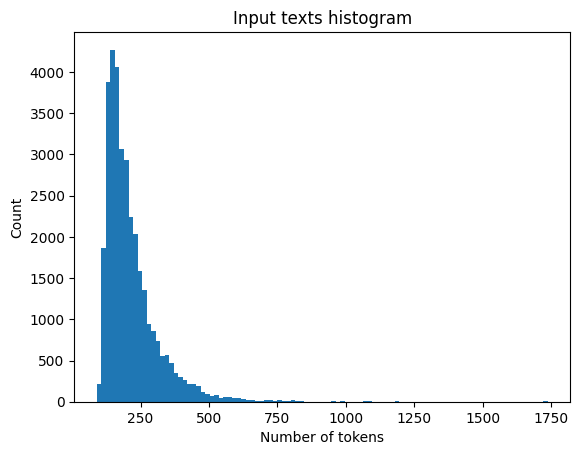

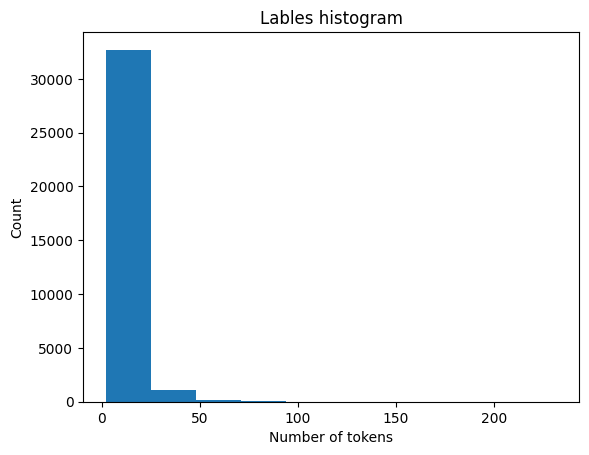

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# your_code


plt.hist(input_tokens, bins=100)
plt.title("Input texts histogram")
plt.xlabel("Number of tokens")
plt.ylabel("Count")
plt.show()

plt.hist(labels_tokens, bins=10|0)
plt.title("Lables histogram")
plt.xlabel("Number of tokens")
plt.ylabel("Count")
plt.show()


// odpowiedź

Niewiele tekstów wejściowych dzielonych jest na więcej niż 500 tokenów. Najwięcej tekstów ma mniej niż 250 tokenów.\
Odpowiedzi zwykle mają długość mniejszą niż 25 tokenów. Zdarzają się też odpowiedzi podzielona na 25-50 tokenów, ale powyżej liczby 50 tokenów znajduje się już niewielka liczba przykładów.

Przyjmiemy założenie, że teksty wejściowe będą miały maksymalnie 256 tokenów, a odpowiedzi do długości 32 tokenów.

W poniższym kodzie uwzględniamy również fakt, że przy obliczaniu funkcji straty nie interesuje nas wliczanie tokenów wypełnienia (PAD), gdyż ich udział byłby bardzo duży, a nie wpływają one w żaden pozytywny sposób na ocenę poprawności działania modelu.

Konteksty (pytanie + kontekst odpowiedzi) ograniczamy do 256 tokenów, ze wzgędu na ograniczenia pamięciowe (zajętość pamięci dla modelu jest proporcjonalna do kwadratu długości tekstu). Dla kontekstów nie używamy parametru `padding`, ponieważ w trakcie treningu użyjemy modułu, który automatycznie doda padding, tak żeby wszystkie sekewncje miały długość najdłuższego tekstu w ramach paczki (moduł ten to `DataCollatorForSeq2Seq`).

In [67]:
def preprocess_function(examples):
    result = plt5_tokenizer(examples["text"], truncation=True, max_length=256)
    targets = plt5_tokenizer(
        examples["labels"], truncation=True, max_length=32, padding=True
    )
    target_ids = [
        [(l if l != plt5_tokenizer.pad_token_id else -100) for l in e]
        for e in targets["input_ids"]
    ]
    result["labels"] = target_ids
    return result


tokenized_datasets = datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/34028 [00:00<?, ? examples/s]

Map:   0%|          | 0/5563 [00:00<?, ? examples/s]

Następnie weryfkiujemy, czy przetworzone teksty mają poprawną postać.

In [69]:
print(tokenized_datasets["train"][0].keys())
print(tokenized_datasets["train"][0]["input_ids"])
print(tokenized_datasets["train"][0]["labels"])
print(len(tokenized_datasets["train"][0]["input_ids"]))
print(len(tokenized_datasets["train"][0]["labels"]))

dict_keys(['text', 'labels', 'input_ids', 'attention_mask'])
[21584, 291, 639, 402, 11586, 292, 23822, 267, 1269, 8741, 280, 24310, 42404, 305, 373, 1525, 15643, 291, 2958, 273, 19605, 6869, 271, 298, 2256, 7465, 394, 540, 2142, 259, 17542, 13760, 10331, 9511, 322, 31220, 261, 358, 348, 267, 7243, 430, 470, 271, 39908, 20622, 2178, 18204, 308, 8439, 2451, 259, 1974, 455, 540, 2142, 1283, 272, 994, 525, 259, 15697, 1978, 267, 264, 644, 259, 14988, 19434, 265, 1109, 287, 274, 357, 259, 21308, 264, 525, 259, 35197, 305, 265, 793, 823, 259, 25318, 2750, 4724, 31015, 21207, 4162, 40335, 18058, 259, 274, 4862, 7030, 261, 5269, 259, 658, 497, 261, 6971, 1890, 35042, 267, 266, 3260, 644, 259, 14988, 19434, 1187, 20919, 284, 27584, 19605, 1230, 2555, 259, 12531, 7278, 3845, 8726, 10486, 1187, 10676, 261, 996, 347, 260, 2548, 2142, 525, 259, 15697, 1978, 309, 27648, 31887, 19605, 259, 274, 4931, 36525, 37011, 4162, 10036, 7141, 265, 6340, 266, 465, 346, 269, 3648, 4383, 6704, 294, 465, 567, 2142

## Ładowanie modelu

Dla problemu odpowiadania na pytania potrzebować będziemy innego pre-trenowanego modelu oraz innego przygotowania danych. Jako model bazowy wykrzystamy polski wariant modelu T5 - [plT5](https://huggingface.co/allegro/plt5-base). Model ten trenowany był w zadaniu *span corruption*, czyli zadani polegającym na usunięciu fragmentu tekstu. Model na wejściu otrzymywał tekst z pominiętymi pewnymi fragmentami, a na wyjściu miał odtwarzać te fragmenty. Oryginalny model T5 dodatkowo pretrenowany był na kilku konkretnych zadaniach z zakresu NLP (w tym odpowiadaniu na pytania). W wariancie plT5 nie przeprowadzono jednak takiego dodatkowego procesu.

Poniżej ładujemy model dla zadania, w którym model generuje tekst na podstawie innego tekstu (tzn. jest to zadanie zamiany tekstu na tekst, po angielsku zwanego też *Sequence-to-Sequence*).

In [70]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("allegro/plt5-base")

pytorch_model.bin:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

W celu poprawy szybkości treningu  moglibyśmy użyć podobnej metody jak przy klasyfikacji. Istnieją jednak bardziej efektywne metody, np. low-rank adaptation (LoRA), które dokomponują macierze wag na dwie macietze o mniejszej liczbie parameyrów. Są one szczególnie istotne dla uczenia dużych modeli. Dzięki bibliotece PEFT ich użycie jest bardzo proste. Skorzystamy zatem z LoRA przy tworzeniu modelu QA.

W pierwszej kolejności konfigurujemy metodę:

In [71]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

Teraz opakowujemy oryginalny model w model PEFT. Oryginalny model nie będzie modyfikowany. Musimy jednak pamietać żeby wszędzie używać modelu PEFT.

In [72]:
peft_model = get_peft_model(model, lora_config)
print_trainable_parameters(peft_model)

trainable params: 3,538,944 || all params: 278,641,920 || trainable%: 1.2701%


1.2700687678293345

Widzimy, że liczba modyfikowalnych parametrów jest bardzo mała względem oryginalnego modelu.

## Trening modelu QA

Ostatnim krokiem przed uruchomieniem treningu jest zdefiniowanie metryk, wskazujacych jak model radzi sobie z problemem. Wykorzystamy dwie metryki:
* *exact match* - która sprawdza dokładne dopasowanie odpowiedzi do wartości referencyjnej, metryka ta jest bardzo restrykcyjna, ponieważ pojedynczy znak będzie powodował, że wartość będzie niepoprawna,
* *blue score* - metryka uwzględniająca częściowe dopasowanie pomiędzy odpowiedzią a wartością referencyjną, najczęściej używana jest do oceny maszynowego tłumaczenia tekstu, ale może być również przydatna w ocenie wszelkich zadań, w których generowany jest tekst.

Wykorzystujemy bibilotekę `evaluate`, która zawiera definicje obu metryk.

Przy konwersji identyfikatorów tokenów na tekstu zamieniamy również z powroten tokeny o wartości -100 na identyfikatory paddingu. W przeciwnym razie dostaniemy błąd o nieistniejącym identyfikatorze tokenu.

W procesie treningu pokazujemy również różnicę między jedną wygenerowaną oraz prawdziwą odpowiedzią dla zbioru ewaluacyjnego. W ten sposób możemy śledzić co rzeczywiście dzieje się w modelu.

In [73]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import numpy as np
import evaluate

exact = evaluate.load("exact_match")
bleu = evaluate.load("bleu")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.where(predictions != -100, predictions, plt5_tokenizer.pad_token_id)
    decoded_preds = plt5_tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, plt5_tokenizer.pad_token_id)
    decoded_labels = plt5_tokenizer.batch_decode(labels, skip_special_tokens=True)
    print("prediction: " + decoded_preds[0])
    print("reference : " + decoded_labels[0])

    result = exact.compute(predictions=decoded_preds, references=decoded_labels)
    result = {**result, **bleu.compute(predictions=decoded_preds, references=decoded_labels)}
    del result["precisions"]

    prediction_lens = [np.count_nonzero(pred != plt5_tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return result

## Zadanie 7 (0.5 punkty)



Korzystając z klasy Seq2SeqTrainingArguments zdefiniuj następujące parametry trenignu:
* inny katalog z wynikami
* liczba epok: 2
* wielkość paczki: 24 (jeśli Twoja karta ma 16GB VRAM)
* ewaluacja co 200 kroków,
* szybkość uczenia: 1e-3
* optymalizator: adafactor
* maksymalna długość generowanej odpowiedzi: 32,
* akumulacja wyników ewaluacji: 4
* generowanie wyników podczas ewaluacji

**W treningu nie używamy optymalizacji FP16!** Jej użycie spowoduje, że model nie będzie się trenował. Jeśli chcesz użyć optymalizacji, to możesz skorzystać z **BF16**.

Argumenty powinny również wskazywać, że przeprowadzoany jest proces uczenia i ewaluacji.

In [76]:
arguments = Seq2SeqTrainingArguments(
    output_dir=path + "/output/zad2",
    do_train=True,
    do_eval=True,

    eval_strategy="steps",
    eval_steps=200,

    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,

    learning_rate=1e-03,
    num_train_epochs=2,

    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=50,

    save_strategy="steps",
    save_steps=100,
    save_total_limit=1,

    optim = 'adafactor',
    generation_max_length=32,
    eval_accumulation_steps=4,
    predict_with_generate=True,

    report_to=[]
)


## Zadanie 8 (0.5 punktu)

Utwórz obiekt trenujący `Seq2SeqTrainer`, za pomocą którego będzie trenowany model odpowiadający na pytania.

Obiekt ten powinien:
* wykorzystywać model `plt5-base`,
* wykorzystywać zbiór `train` do treningu,
* wykorzystawać zbiór `dev` do evaluacji,
* wykorzystać klasę batchującą (`data_collator`) o nazwie `DataCollatorWithPadding`.

In [79]:
from transformers import DataCollatorForSeq2Seq, DataCollatorWithPadding

# your_code

seed = 42

trainer = Seq2SeqTrainer(
    model=model,
    args=arguments,
    train_dataset=tokenized_datasets["train"].shuffle(seed=seed),
    eval_dataset=tokenized_datasets["dev"].shuffle(seed=seed),
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=plt5_tokenizer)

)



In [ ]:
%reload_ext tensorboard
%tensorboard --logdir output_qa/runs # gdrive/MyDrive/poquad/output_qa/runs

Mając przygotowane wszystkie dane wejściowe możemy rozpocząć proces treningu.

**Uwaga**: proces treningu na Google Colab z wykorzystaniem akceleratora zajmuje ok. 1 godziny. Uruchomienie treningu na CPU może trwać ponad 1 dzień!

Możesz pominąć ten proces i w kolejnych krokach wykorzystać gotowy model `apohllo/plt5-base-poquad`, który znajduje się w repozytorium Hugginface.

In [ ]:
#14m @ 4080
trainer.train()

## Zadanie 9 (1.5 punkt)

Korzystając z wywołania `generate` w modelu, wygeneruj odpowiedzi dla 1 kontekstu i 10 pytań dotyczących tego kontekstu. Pamiętaj aby zamienić identyfikatory tokenów na ich treść. Możesz do tygo wykorzystać wywołanie `decode` z tokenizera.

Jeśli w poprzednim punkcie nie udało Ci się wytrenować modelu, możesz skorzystać z modelu `apohllo/plt5-base-poquad`.

Oceń wyniki (odpowiedzi) generowane przez model.

In [ ]:
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained("apohllo/plt5-base-poquad")

In [107]:
# https://mccmedale.pl/handball-kilka-slow-o-pilce-recznej/

text = """
Chcąc dokopać się do korzeni piłki ręcznej, należałoby skierować poszukiwania nawet w stronę starożytnej Grecji i Rzymu. To tam rozrywkę dostarczały zbliżone mechaniką gry takie jak urania czy herpastum. To jednak zamierzchłe czasy, a dzisiejszy handball, choć podobny, znacząco różni się od swoich starożytnych protoplastów.

Nowożytna historia piłki ręcznej sięga końca XIX wieku. To właśnie wtedy, Holger Nielsen, duński “ojciec” dyscypliny spisał zasady, a następnie – w 1906 roku – opublikował je tworząc podwaliny dzisiejszego handballa. Dyscyplina zyskiwała na popularności przede wszystkim w Danii, Niemczech, Szwecji i Norwegii. To od dwóch pierwszych państw wzięły się też odmiany piłki ręcznej. Wersja duńska przewidywała zespoły złożone z 7 osób, natomiast niemiecka z 11. Z biegiem lat pierwsza z nich wyparła drugą, i dziś, to właśnie 7-osobowe zespoły walczą o zwycięstwa na boiskach całego świata.

Jedną z nazw, którymi określana jest piłka ręczna w Polsce jest szczypiorniak. Funkcjonuje ona praktycznie od początku obecności handballa w naszym kraju, czyli od 1918 roku. To właśnie wtedy legioniści z I i III Brygady Legionów Polskich, których internowali Niemcy, zapoznali się z zasadami piłki ręcznej przedstawionymi przez pilnujących ich strażników. Miejsce internowania znajdowało się pod Kaliszem, w miejscowości Szczypiorno, i to właśnie od niej wzięło się używane do dziś określenie.

Podobnie, jak w innych sportach drużynowych, tak i w piłce ręcznej głównym celem gry jest zdobycie większej liczby punktów niż drużyna przeciwna. Zawodnicy rywalizują na hali, na prostokątnym boisku o wymiarach 40 x 20 metrów. Bramki znajdują się na środku krótszych boków i mają 3 metry szerokości oraz 2 metry wysokości.

Walka na boisku trwa łącznie 60 minut, a spotkanie podzielone jest na dwie połowy po 30 minut. Pomiędzy nimi zawodnicy mogą odpocząć na 10-15 minutowej przerwie. Jeżeli w regulaminowym czasie gry dojdzie do remisu, organizowana jest dogrywka – 2 połowy po 5 minut. Przy kolejnym remisie ponownie dochodzi do dogrywki, a jeśli i ona nie przyniesie rozwiązania, rozgrywane są rzuty karne. Co ważne, handball przewiduje zatrzymywanie odmierzania czasu gry w kilku sytuacjach, m.in. nałożenia kary wykluczenia lub dyskwalifikacji.

Do rywalizacji stają dwie drużyny składające się maksymalnie z 16 zawodników – 7 znajdujących się na boisku i 9 rezerwowych. Zmiany dokonywane są w trakcie gry, a zawodnicy rezerwowi mogą znaleźć się na boisku wielokrotnie i w każdej chwili, bez konieczności zgłaszania tego faktu prowadzącym spotkanie. Zmiana jest zgodna z przepisami, gdy zmieniany zawodnik znajduje się już poza boiskiem.

Zawodnicy mogą trzymać piłkę nie dłużej niż 3 sekundy, a trzymając ją w dłoni, nie mogą wykonać więcej niż 3 kroków. To właśnie dlatego zawodnicy uprawiający handball poza celnością rzutów, ćwiczyć muszą także kozłowanie.

O zwycięstwie w spotkaniu decydują bramki. Gol zaliczany jest w momencie, w którym piłka przekroczy linię bramkową całym swoim obwodem, a zawodnik, który wykonał rzut, ani żaden inny członek drużyny, w tym czasie nie naruszył żadnych przepisów gry.

Organizowane od 1938 roku mistrzostwa świata to turniej przeznaczony dla narodowych reprezentacji. Kraj, który zwycięży może przez pewien okres (do kolejnych mistrzostw) szczycić się mianem najlepszego na świecie. Za organizację kolejnej, 28 edycji wydarzenia odpowiada Polska i Szwecja.

Mistrzostwa kontynentalne, to cykliczne wydarzenia, które mają za zadanie wyłonić najlepszą drużynę narodową danego kontynentu. Zwycięzcy turniejów kwalifikują się automatycznie do mistrzostw świata. Za organizację mistrzostw Europy odpowiedzialny jest EHF.

Kibiców z Polski zainteresować powinna Liga Mistrzów piłkarzy ręcznych. Te europejskie rozgrywki przeznaczone są dla najlepszych drużyn klubowych ze “starego kontynentu”. Od sezonu 2020/2021, w rozgrywkach udział bierze 16 zespołów podzielonych na 2 grupy po 8 drużyn.
"""

questions = ["Jaki jest cel gry w piłkę ręczną?",
             "Ile trwa mecz piłki ręcznej?",
             "Ile kroków mogą wykonać zawodnicy, trzymając piłkę w dłoni?",
             "Kto jest nazywany ojcem piłki ręcznej?",
             "W jakim kraju używa się nazwy 'szczypiorniak'?",
             "Za co odpowiedzialna jest organizacja EHF?",
             "W którym roku zorganizowano pierwsze mistrzostwa świata?",
             "Ile zmian można dokonać podczas meczu?",
             "Jakie są wymiary bramki do gry w piłkę ręczną?",
             "W jakich sytuacjach zatrzymuje się czas podczas gry?",
             "Co się dzieje w przypadku remisu?"
             ]

# len(questions)

In [110]:
# your_code
tokenizer = AutoTokenizer.from_pretrained("apohllo/plt5-base-poquad")

model.eval()

i = 0

for q in questions:
  i += 1
  data = f"Pytanie: {q}Kontekst: {text}"
  data_tokenized = tokenizer.encode(data, return_tensors='pt')
  outputs = model.generate(data_tokenized.to(device))
  answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)
  print(str(i) + '. ' + q)
  print("- " + answer[0])
  print()




/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


1. Jaki jest cel gry w piłkę ręczną?
- zdobycie większej liczby punktów niż drużyna przeciwna

2. Ile trwa mecz piłki ręcznej?
- 60 minut

3. Ile kroków mogą wykonać zawodnicy, trzymając piłkę w dłoni?
- 3

4. Kto jest nazywany ojcem piłki ręcznej?
- Holger Nielsen

5. W jakim kraju używa się nazwy 'szczypiorniak'?
- w Polsce

6. Za co odpowiedzialna jest organizacja EHF?
- organizację mistrzostw Europy

7. W którym roku zorganizowano pierwsze mistrzostwa świata?
- 1938

8. Ile zmian można dokonać podczas meczu?
- trzy

9. Jakie są wymiary bramki do gry w piłkę ręczną?
- 40 x 20 metrów

10. W jakich sytuacjach zatrzymuje się czas podczas gry?
- m.in. nałożenia kary wykluczenia lub dyskwalifikacji

11. Co się dzieje w przypadku remisu?
- zostaje rozegrana dogrywka



// odpowiedź
Na większość pytań model podał prawidłową odpowiedź, która jest również poprawna pod względem poprawności językowej. Błędna odpowiedź pojawia się tylko przy pytaniu numer 8 - uważam jednak, że jest ono trudniejsze od pozostałych, ponieważ odpowiedź nie jest bezpośrednio podana w tekście, a wynika z kontekstu wypowiedzi.

# Zadanie dodatkowe (3 punkty)

Stworzenie pełnego rozwiązania w zakresie odpowiadania na pytania wymaga również znajdowania kontekstów, w których może pojawić się pytanie.

Obenie istnieje coraz więcej modeli neuronalnych, które bardzo dobrze radzą sobie ze znajdowaniem odpowiednich tekstów. Również dla języka polskiego następuje tutaj istotny postęp. Powstała m.in. [strona śledząca postępy w tym zakresie](https://huggingface.co/spaces/sdadas/pirb).

Korzystając z informacji na tej stronie wybierz jeden z modeli do wyszukiwania kontekstów (najlepiej o rozmiarze `base` lub `small`). Zamień konteksty występujące w zbiorze PoQuAD na reprezentacje wektorowe. To samo zrób z pytaniami występującymi w tym zbiorze. Dla każdego pytania znajdź kontekst, który według modelu najlepiej odpowiada na zadane pytanie. Do znalezienia kontekstu oblicz iloczyn skalarny pomiędzy reprezentacją pytania oraz wszystkimi kontekstami ze zbioru. Następnie uruchom model generujący odpowiedź na znalezionym kontekście. Porównaj wyniki uzyskiwane w ten sposób, z wynikami, gdy poprawny kontekst jest znany.

W celu przyspieszenie obliczeń możesz zmniejszyć liczbę pytań i odpowiadających im kontekstów. Pamiętaj jednak, żeby liczba kontekstów była odpowiednio duża (sugerowana wartość min. to 1000 kontekstów), tak żeby znalezienie kontekstu nie było trywialne.

Zastanów się jakiej metryki użyjesz do oceny znalezionych odpowiedzi. Przedstaw wyniki oceny odpowiedzi pełnego rozwiązania według wybranej metryki.